<h1><u>Planning Stage: Data Description & Exploratory Data Analysis and Visualization</u></h1>

<h3> Benjamin Nguyen (90643321) - Group 43 </h3>

<h3>Dataset: <a href="https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries/data">Job Salaries</a></h3>

<br><br>

<h2><u>Data Description</u></h2>

This dataset contains a sample of <b>607</b> data records from data science related jobs, which includes <b>11 variables</b> related to them:
- <b>work_year</b> (numeric): The year the salary was paid.
- <b>experience_level</b> (string): The experience level for that job during its associated year, with 4 possible values:
    - EN: Entry-level / Junior
    - MI: Mid-level / Intermediate
    - SE: Senior-level / Expert
    - EX: Executive-level / Director
- <b>employment_type</b> (string): The employment type for the job, with 4 possible values:
    - PT: Part-time
    - FT: Full-time
    - CT: Contract
    - FL: Freelance
- <b>job_title</b> (string): The role associated with the job for its associated year.
- <b>salary</b> (numeric): The total gross amount paid for the job.
- <b>salary_currency</b> (string): The currency of the associated salary (ISO 4217 currency code).
- <b>salary_in_usd</b> (numeric): The associated salary amount in USD (calculated using USD rate for the associated year).
- <b>employee_residence</b> (string): The employee's primary country of residence during associated job's work year.
- <b>remote_ratio</b> (numeric): The overall amount of work done remotely, with 3 possible values:
    - 0: No remote work (<20%)
    - 50: Partially remote
    - 100: Fully remote (>80%)
- <b>company_location</b> (string): The country of the employer's main office (as ISO 3166 country code).
- <b>company_size</b> (string): The average number of people that worked for the company during the associated year, has 3 possible values:
    - S: Less than 50 employees (small)
    - M: 50 to 250 employees (medium)
    - L: More than 250 employees (large)

Data was collected through the years 2022-2024 from all parts of the world, including the US, Canada, India, Japan, Ireland, Austrlia, etc.

<br><br>

<h2><u>Question</u></h2>

A possible question of interest that can be derived from the dataset is: 
- <b>Do the aspects of a job have an effect on the salary given to its associated employee, and if so, which ones?</b>

The dataset has a lot of variables that can potentially help with to answer this question, for example, experience level, employment type, and company size. These variables should intuitively play a part on given salaries, since the budget allocated to the job can have these reasons for its constraints. 

This question is focused on inference, because it would be helpful to use knowledge learned from this data to understand what variables dictate the salary given to an employee. One reason why this question is helpful, is the potential to inform people looking for data science jobs using the variables that correlate to higher salaries, while also informing companies paying those salaries on if these findings make sense for them or not. 

<br><br>

<h2><u>Exploratory Data Analysis and Visualization</u></h2>

<h3>Imports</h3>

In [1]:
library(tidyverse)
library(glmnet)
library(broom)
library(leaps)
library(repr)
library(faraway)
library(mltools)
library(cowplot)
library(GGally)
library(modelr)
library(data.table)
library(AER)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8


Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘

<br>

<h3>Loading and tidying the data</h3>

Due to lack of standardization, and the presence of the standardized version `salary_in_usd`, the original `salary` column will not be used within our analysis, hence `salary_currency` is not needed. 

A potential problem down the line is the numerous potential values within some fields (`job_title`, `employee_residence`, `company_location`), which can increase computational power and reduce interpretability of our models. We will exclude them from our analysis.

Since some predictors in our dataset are categorical and are strings, we have to convert them into factors so our model can interpret them correctly.

In [2]:
# drop first column since it is just describing the row's index
# removing the column salary, since we can use salary_in_usd - its standardized version instead, for ease of comparison
salaries_df <- read_csv("data/ds_salaries.csv", col_types = cols())[, -1] %>%
    select(-job_title, -employee_residence, -company_location, -salary_currency, -salary)

salaries_df$experience_level <- as.factor(salaries_df$experience_level)
salaries_df$employment_type <- as.factor(salaries_df$employment_type)
salaries_df$remote_ratio <- as.factor(salaries_df$remote_ratio)
salaries_df$company_size <- as.factor(salaries_df$company_size)

head(salaries_df)

New names:
• `` -> `...1`


work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_size
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>
2020,MI,FT,79833,0,L
2020,SE,FT,260000,0,S
2020,SE,FT,109024,50,M
2020,MI,FT,20000,0,S
2020,SE,FT,150000,50,L
2020,EN,FT,72000,100,L


In [3]:
# checking for missing values within each column
colSums(is.na(salaries_df))

work_year experience_level  employment_type    salary_in_usd 
               0                0                0                0 
    remote_ratio     company_size 
               0                0

<br>

<h3>Visualizations</h3>

We will explore the relationships between year of salary paid to the employee, experience level, and company size in regards to these variables' associated mean employee salaries separately. This is important to explore, because we need to know if there are hints of  correlation between some of the dataset's variables and employee salaries, in order for our later statistical analysis to be worthwhile of our time and (potentially) budget.

As above, all mentions of salary should be presumed to be in USD.

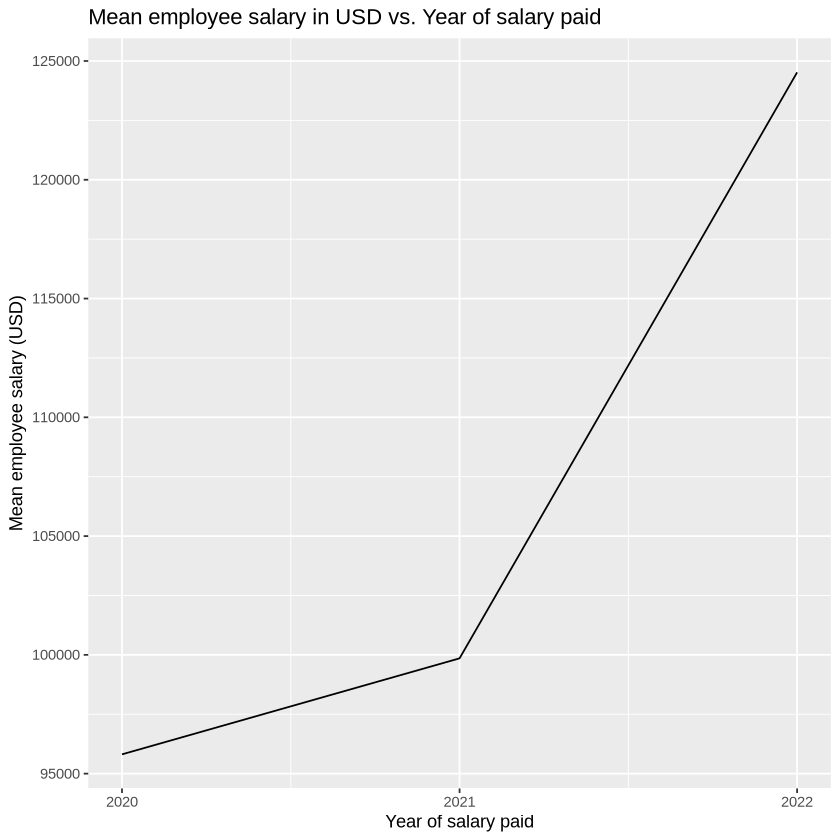

In [4]:
salaries_df %>%
    group_by(work_year) %>%
    summarise(mean_salary_usd = mean(salary_in_usd)) %>%
    ggplot() +
    geom_path(aes(work_year, mean_salary_usd)) +
    scale_x_continuous(breaks = c(2020, 2021, 2022)) +
    labs(title = "Mean employee salary in USD vs. Year of salary paid", x = "Year of salary paid", y = "Mean employee salary (USD)")

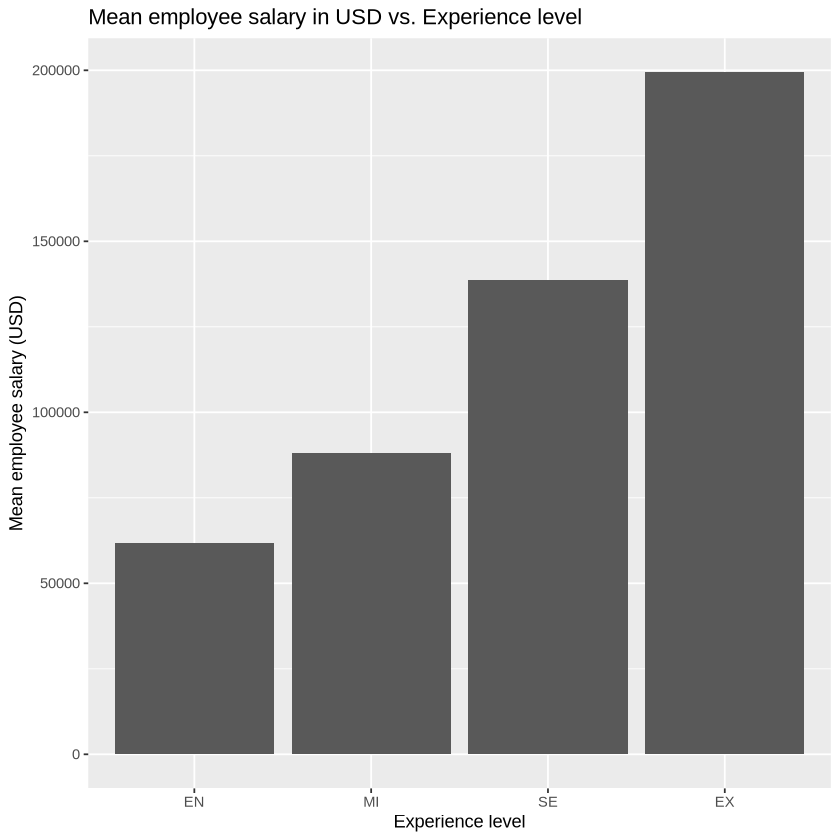

In [5]:
#https://www.geeksforgeeks.org/how-to-change-the-order-of-bars-in-bar-chart-in-r/
salaries_df %>%
    group_by(experience_level) %>%
    summarise(mean_salary_usd = mean(salary_in_usd)) %>%
    ggplot() +
    geom_col(aes(reorder(experience_level, +mean_salary_usd), mean_salary_usd)) +
    labs(title = "Mean employee salary in USD vs. Experience level", x = "Experience level", y = "Mean employee salary (USD)")

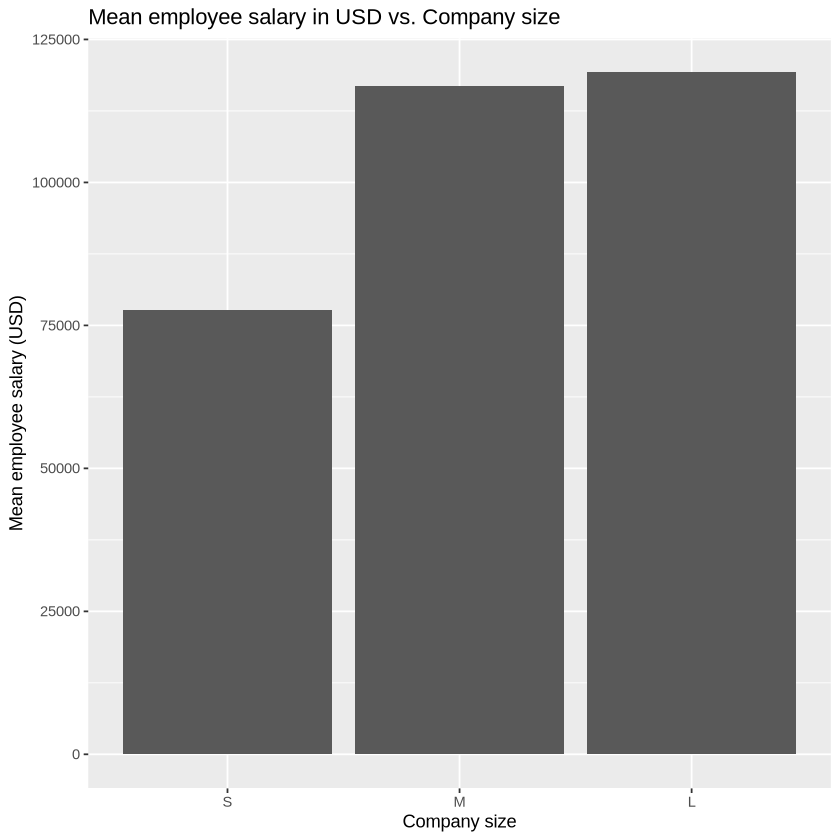

In [6]:
salaries_df %>%
    group_by(company_size) %>%
    summarise(mean_salary_usd = mean(salary_in_usd)) %>%
    ggplot() +
    geom_col(aes(reorder(company_size, +mean_salary_usd), mean_salary_usd)) +
    labs(title = "Mean employee salary in USD vs. Company size", x = "Company size", y = "Mean employee salary (USD)")

All three plots show that the year of salary paid to the employee, experience level, and company size, have a positive correlation with the employee's salary.

<br><br>

<h2><u>Methods and Plan</u></h2>

<p><b>Note: Changes are added to the sections done for assignment 1, please view the entire notebook for full context.</b></p>

We will be using a <b>multiple linear regression</b> (MLR) model for our analysis, using an additive model of all our available predictors, retrieving the coefficients of each predictor (and compared to their reference levels if the predictor is a factor) and seeing if there is a significant chance they affect data science salaries by their p-values, using a significance level of $\alpha=0.05$. We reject the null hypothesis that the predictors do not influence the target if the predictor's p-value fall below this significance level.

This method is appropriate because of the potential for multiple variables to affect these data science job salaries. Since our question of interest is focused on inference, interpretability is an important factor to consider, and linear models are very interpretable due to the coefficients associated with each predictor it provides. The magnitude and signs of these coefficients help us understand quickly which variables have/not have an effect on salaries.

However, we must also be aware of the potential for some variables to not affect these salaries at all. Very importantly, we need to determine if there is multicollinearity within our predictors, since it can be difficult to determine how collinear variables are separately associated with the response. One way we can achieve this is by checking VIF values for our predictors.

By utilizing an MLR model, some assumptions must be made:
- The relationship between our predictors (X) and our response variable (Y) is linear.
- The errors are independent of each other.
- The responses are normally distributed, at each level of X.
- The standard deviations of our responses are equal for all levels of X.
- The predictors are not correlated with one another.

Hence, some more EDA and potential preprocessing is needed on the data before we implement our model and perform our analysis. Our model will be unreliable if one of these assumptions is violated.

However, by using MLR, there are also some limitations and weaknesses to be aware of:
- Since MLR is a linear model, it cannot capture nonlinear relationships or complex relationships. However, using interaction terms can help with this.
- If the predictors used in the MLR model are highly correlated with one another (multicollinearity, described above), our resulting standard errors of coefficients can be inflated, which reduces the precision of the model, and makes it harder to interpret.

<br><br>

<h2><u>Computational Code and Output</u></h2>

<h3>Checking that LR assumptions are being upheld</h3>

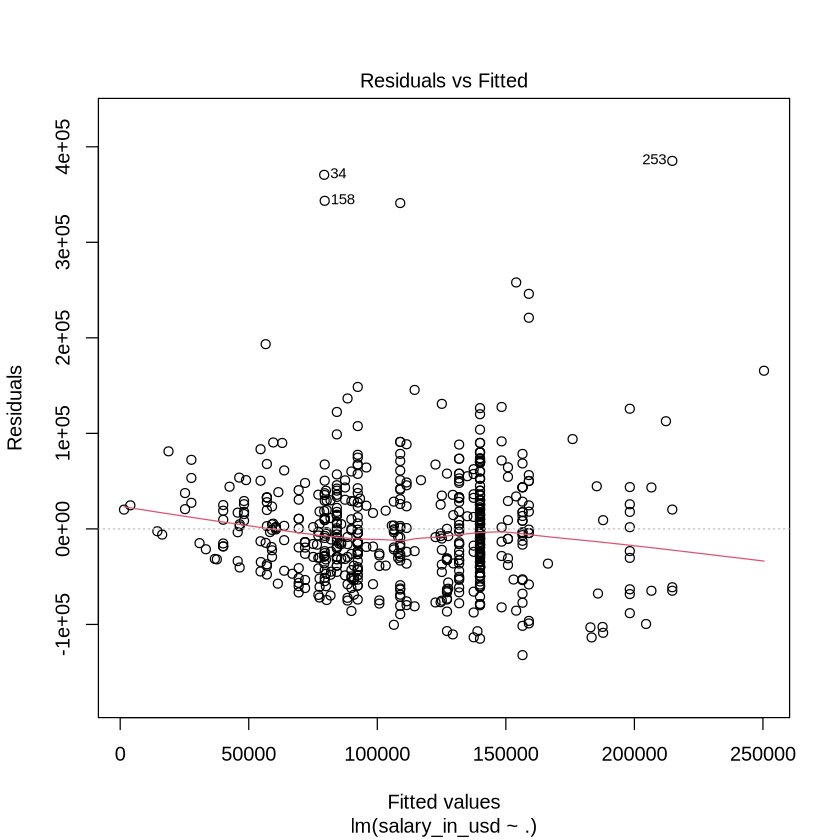

In [7]:
base_model <- lm(salary_in_usd ~ ., salaries_df)

plot(base_model, 1)

Since the plot shows uniform and scattered points, this indicates a constant variance for all levels of X. Also, this constant variance for all levels of X means that the relationship between the predictors and the target is linear.

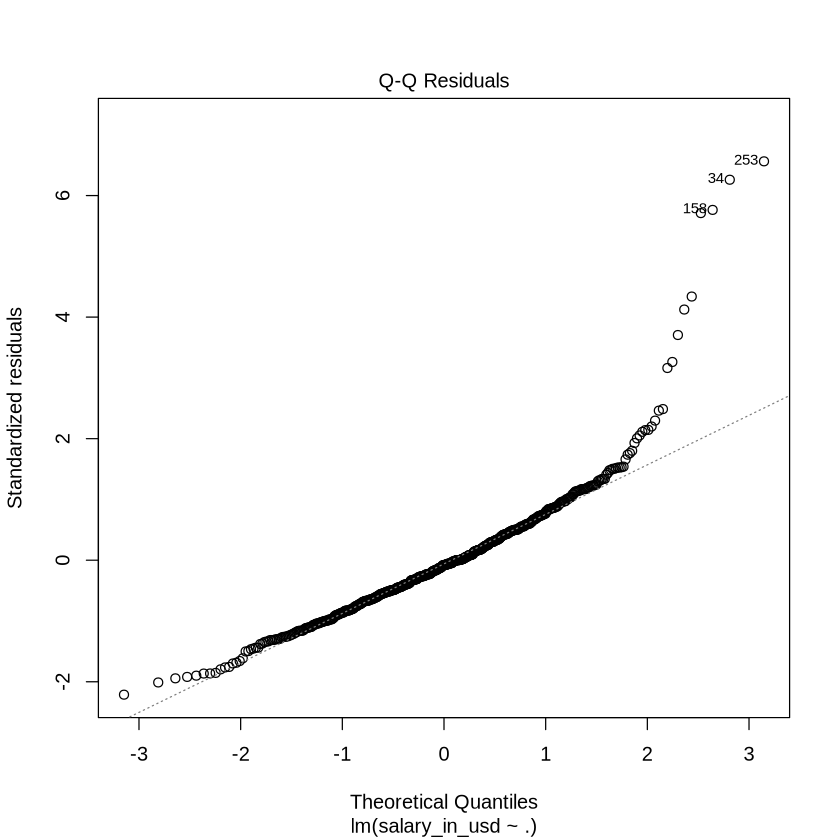

In [8]:
plot(base_model, 2)

Since most of the points lie on the 45° dotted line, it suggests that the errors are normally distributed.

<br>

In [9]:
round(vif(base_model), 3)

,GVIF,Df,GVIF^(1/(2*Df))
work_year,1.567,1,1.252
experience_level,1.246,3,1.037
employment_type,1.102,3,1.016
remote_ratio,1.208,2,1.048
company_size,1.547,2,1.115


Since the VIF values are relatively small, we can conclude that these predictors are not correlated with one another.

<br>

<h3>Model Results</h3>

In [10]:
tidy(base_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-4837934.072,8909361.438,-0.5430169,5.873215e-01
work_year,2466.742,4409.128,0.5594626,5.760565e-01
experience_levelEX,126310.505,13643.113,9.2581879,3.726834e-19
experience_levelMI,20488.053,7907.018,2.5911226,9.800979e-03
experience_levelSE,68049.259,7963.549,8.5450919,1.080540e-16
employment_typeFL,-113141.179,40580.839,-2.7880443,5.472220e-03
employment_typeFT,-67045.657,27215.618,-2.4634993,1.404069e-02
employment_typePT,-90780.750,33353.183,-2.7218017,6.682866e-03
remote_ratio50,-21252.788,8563.547,-2.4817739,1.334796e-02


<br>

Via the model output table above, from the p-values of each predictor (and their categorical value based on their reference level), `experience_level`, `employment_type`, `remote_ratio` being 50% (compared to it being 25%) and `company_size` have p-values under 0.05, meaning that for these predictors, we can reject the null hypothesis, hence we can conclude that these predictors have an impact on data science job salaries. The job's experience level being an executive-level, mid-level and senior-level would give a potential employee a higher salary than if they were entry-level, and the job's employment type being a contractor usually pays more than full-time, part-time and freelance jobs. The job's amount of work done remotely being 100% would also bring the salary up compared to it being 0%, and the company's size being large (more than 250 employees) would give the job a higher salary than if the company's size were to be medium (50-250 employees), and small (less than 50 employees). Furthermore, the year that the salary of the job was paid might not have an effect on the salary itself, and if the job was partially remote, it also might not have a difference on the salary compared to if the job was fully in person.